### 1. Introduction

In this project, we aim to build a robust time series forecasting model using a 2-step hybrid approach to capture trend, seasonality, cycles for S&P500 data. We'll use Yahoo Finance to obtain the data and Python libraries such as pandas, numpy, statsmodels, sklearn, and XGBoost for our analysis. We will also use some resources from kaggle such as the periodogram function, which ended up being useful for analyzing the seasonality of the S&P500


###2. Data Preparation

#### Load Data

In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Load the S&P500 data from Yahoo Finance
data = yf.download('^GSPC', start='1929-01-01', end='2024-01-01')
data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

# Set the frequency to daily
data.index = pd.to_datetime(data.index)
data = data.asfreq('D').dropna()

# Display the first few rows of the dataset
data.head(10)


[*********************100%%**********************]  1 of 1 completed


,Close
Date,
1929-01-02,24.809999
1929-01-03,24.860001
1929-01-04,24.850000
1929-01-07,24.250000
1929-01-08,24.170000
1929-01-09,24.540001
1929-01-10,24.580000
1929-01-11,24.540001
1929-01-14,24.590000


#### Initial Exploration

The initial plot helps us visualize the overall trend of the S&P 500 closing prices over the years. We can observe the long-term upward trend, as well as significant drops corresponding to major financial crises.


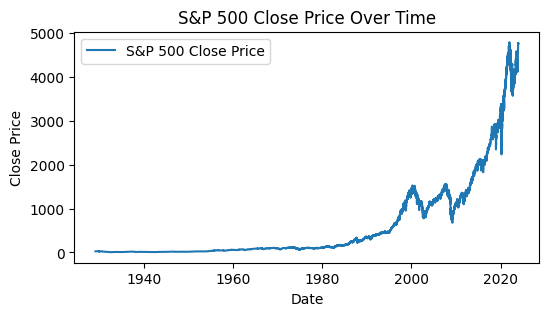

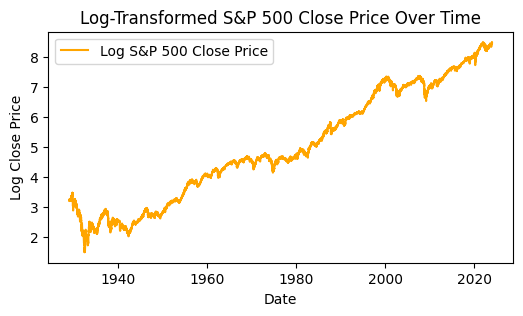

In [19]:
# Plot the closing price over time
plt.figure(figsize=(6, 3))
plt.plot(data['Close'], label='S&P 500 Close Price')
plt.title('S&P 500 Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Apply log transformation to the closing prices
data['Log_Close'] = np.log(data['Close'])

# Plot the log-transformed closing price over time
plt.figure(figsize=(6, 3))
plt.plot(data['Log_Close'], label='Log S&P 500 Close Price', color='orange')
plt.title('Log-Transformed S&P 500 Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log Close Price')
plt.legend()
plt.show()


#### Train-Test Split

The data is split into training and testing sets with an 80/20 ratio to ensure proper evaluation of the model's performance. The training set will be used to build the model, while the testing set will be used to evaluate its accuracy.


In [20]:
# Define the train-test split ratio
train_ratio = 0.8
train_size = int(len(data) * train_ratio)

# Split the data into training and testing sets
train_data = data[:train_size]
test_data = data[train_size:]

# Display the sizes of the training and testing sets
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")


Training set size: 19091
Testing set size: 4773


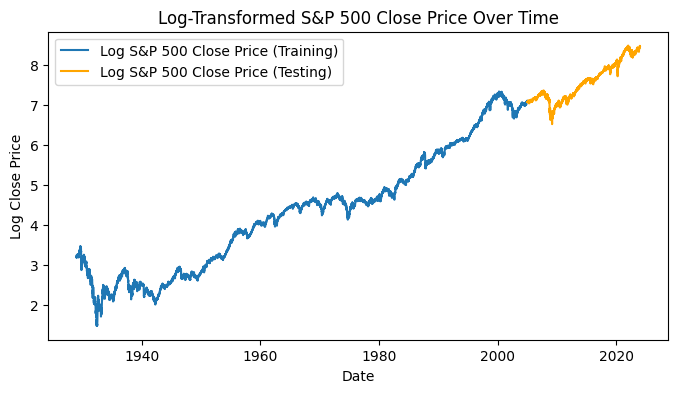

In [21]:
# Apply log transformation to the closing prices
train_data.loc[:, 'Log_Close'] = np.log(train_data['Close'])
test_data.loc[:, 'Log_Close'] = np.log(test_data['Close'])

# Plot the log-transformed closing price over time
plt.figure(figsize=(8, 4))
plt.plot(train_data['Log_Close'], label='Log S&P 500 Close Price (Training)')
plt.plot(test_data['Log_Close'], label='Log S&P 500 Close Price (Testing)', color='orange')
plt.title('Log-Transformed S&P 500 Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log Close Price')
plt.legend()
plt.show()


### **3. Step-by-Step Modeling Approach**

#### **Step 1: Capturing the Trend**

Creating Time Index Feature - We will create a new feature, `time_index`, which will represent the time progression of our data. This feature will be used in our linear regression model to capture the trend in the S&P 500 closing prices. Since a log transformaition was done, a line should be able to capture the trend.


In [22]:
from statsmodels.tsa.deterministic import DeterministicProcess

# Create a time index feature using DeterministicProcess
dp = DeterministicProcess(index=train_data.index, order=1, drop=True)
X_train_trend = dp.in_sample()
X_test_trend = dp.out_of_sample(steps=len(test_data))

# Display the first few rows of the training data with the new Time_Index feature
X_train_trend.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


,trend
Date,
1929-01-02,1.0
1929-01-03,2.0
1929-01-04,3.0
1929-01-07,4.0
1929-01-08,5.0


##### Model the Trend: Linear Regression
We use linear regression to model the trend in the log-transformed closing prices. This involves fitting a linear model to the `Log_Close` prices using the time index feature created by `DeterministicProcess`.


In [23]:
from sklearn.linear_model import LinearRegression

# Define the target variable for the trend model
y_train_trend = train_data['Log_Close']
y_test_trend = test_data['Log_Close']

# Initialize and fit the linear regression model
trend_model = LinearRegression()
trend_model.fit(X_train_trend, y_train_trend)

# Predict the trend for both training and testing sets
train_data.loc[:,'Trend_Pred'] = trend_model.predict(X_train_trend)
test_data.loc[:,'Trend_Pred'] = trend_model.predict(X_test_trend)

# Display the first few rows of the training data with the Trend_Pred feature
train_data.tail()


,Close,Log_Close,Trend_Pred
Date,,,
2005-01-06,1187.890015,7.079934,6.827195
2005-01-07,1186.189941,7.078502,6.827456
2005-01-10,1190.250000,7.081919,6.827717
2005-01-11,1182.989990,7.075800,6.827978
2005-01-12,1187.699951,7.079774,6.828240


##### Visualisation
We visualize the trend by plotting the log-transformed closing prices and the fitted trend line for both training and testing sets on the same plot. We also plot the residuals for both sets on another combined plot.


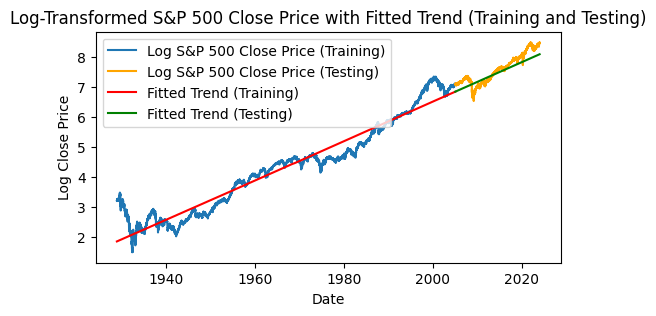

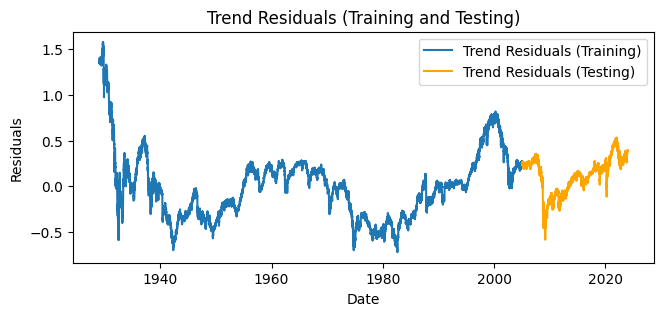

In [24]:
# Combined plot for log-transformed closing prices with the fitted trend line
plt.figure(figsize=(6, 3))
plt.plot(train_data.index, train_data['Log_Close'], label='Log S&P 500 Close Price (Training)')
plt.plot(test_data.index, test_data['Log_Close'], label='Log S&P 500 Close Price (Testing)', color='orange')
plt.plot(train_data.index, train_data['Trend_Pred'], label='Fitted Trend (Training)', color='red')
plt.plot(test_data.index, test_data['Trend_Pred'], label='Fitted Trend (Testing)', color='green')
plt.title('Log-Transformed S&P 500 Close Price with Fitted Trend (Training and Testing)')
plt.xlabel('Date')
plt.ylabel('Log Close Price')
plt.legend()
plt.show()

# Calculate the residuals for the training and testing sets
train_data.loc[:,'Trend_Residual'] = train_data['Log_Close'] - train_data['Trend_Pred']
test_data.loc[:,'Trend_Residual'] = test_data['Log_Close'] - test_data['Trend_Pred']

# Combined plot for residuals
plt.figure(figsize=(7.5, 3))
plt.plot(train_data.index, train_data['Trend_Residual'], label='Trend Residuals (Training)')
plt.plot(test_data.index, test_data['Trend_Residual'], label='Trend Residuals (Testing)', color='orange')
plt.title('Trend Residuals (Training and Testing)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate and print the MSE and R² for the training set
mse_train_trend = mean_squared_error(train_data['Log_Close'], train_data['Trend_Pred'])
r2_train_trend = r2_score(train_data['Log_Close'], train_data['Trend_Pred'])
print(f"Training MSE (Trend): {mse_train_trend}")
print(f"Training R² (Trend): {r2_train_trend}")

# Calculate and print the MSE and R² for the testing set
mse_test_trend = mean_squared_error(test_data['Log_Close'], test_data['Trend_Pred'])
r2_test_trend = r2_score(test_data['Log_Close'], test_data['Trend_Pred'])
print(f"Testing MSE (Trend): {mse_test_trend}")
print(f"Testing R² (Trend): {r2_test_trend}")


Training MSE (Trend): 0.13801320500635902
Training R² (Trend): 0.9375820445868627
Testing MSE (Trend): 0.053589407882306296
Testing R² (Trend): 0.7635421468749591


The high R² values and relatively low MSE for both the training and testing sets indicate that the linear regression model using the `DeterministicProcess` function has effectively captured the trend in the log-transformed S&P 500 closing prices, though it performs slightly better on the training data than on the testing data.

#### **Step 2: Capturing Seasonality (deseasonalizing)**

Creating Time Index Feature - We will create a new feature, `time_index`, which will represent the time progression of our data. This feature will be used in our linear regression model to capture the trend in the S&P 500 closing prices.


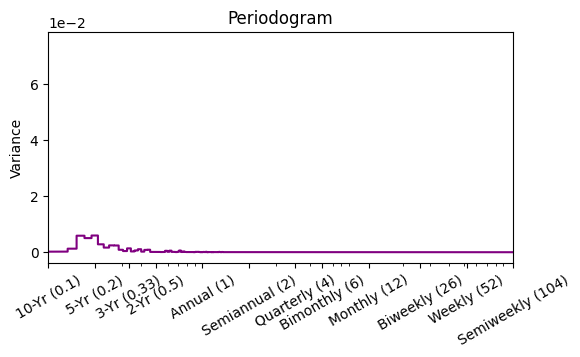

In [26]:
from scipy.signal import periodogram

def plot_periodogram(ts, detrend='linear', ax=None, focus_range=None, linear_scale=False):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )

    if ax is None:
        _, ax = plt.subplots()

    ax.step(frequencies, spectrum, color="purple")

    if linear_scale:
        ax.set_xscale("linear")
        xticks = [1/10, 1/5, 1/3, 1/2, 1, 2, 4, 6, 12, 26, 52, 104]
    else:
        ax.set_xscale("log")
        xticks = [1/10, 1/5, 1/3, 1/2, 1, 2, 4, 6, 12, 26, 52, 104]

    ax.set_xticks(xticks)

    ax.set_xticklabels(
        [
            "10-Yr (0.1)",
            "5-Yr (0.2)",
            "3-Yr (0.33)",
            "2-Yr (0.5)",
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)"
        ],
        rotation=30,
    )

    if focus_range:
        ax.set_xlim(focus_range)

    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax

# Use the function to plot the periodogram for the log-transformed closing prices
fig, ax = plt.subplots(figsize=(6, 3))
plot_periodogram(train_data['Log_Close'], ax=ax, focus_range=(0.1, 104), linear_scale=False)
plt.show()


The periodogram indicates some variance in the lower frequency range, suggesting the presence of cycles with periods longer than one year; we will zoom in to better analyze these longer-term cycles.

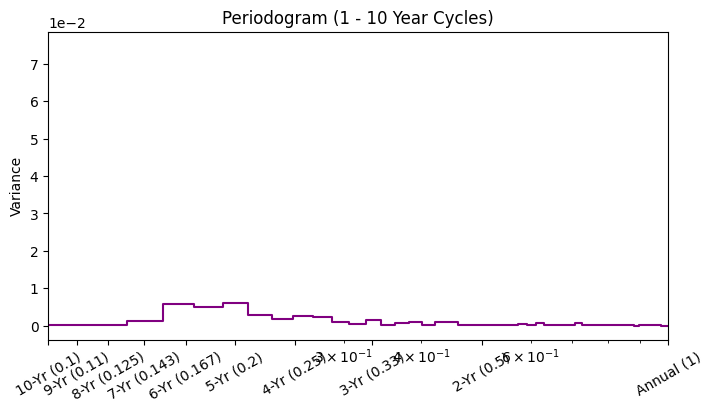

In [27]:
from scipy.signal import periodogram

def plot_periodogram_longterm(ts, detrend='linear', ax=None, focus_range=None, linear_scale=False):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )

    if ax is None:
        _, ax = plt.subplots()

    ax.step(frequencies, spectrum, color="purple")

    if linear_scale:
        ax.set_xscale("linear")
        xticks = [1/10, 1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1]
    else:
        ax.set_xscale("log")
        xticks = [1/10, 1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1]

    ax.set_xticks(xticks)

    ax.set_xticklabels(
        [
            "10-Yr (0.1)",
            "9-Yr (0.11)",
            "8-Yr (0.125)",
            "7-Yr (0.143)",
            "6-Yr (0.167)",
            "5-Yr (0.2)",
            "4-Yr (0.25)",
            "3-Yr (0.33)",
            "2-Yr (0.5)",
            "Annual (1)"
        ],
        rotation=30,
    )

    if focus_range:
        ax.set_xlim(focus_range)

    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram (1 - 10 Year Cycles)")

    return ax

# Use the function to plot the periodogram for the log-transformed closing prices
fig, ax = plt.subplots(figsize=(8, 4))
plot_periodogram_longterm(train_data['Log_Close'], ax=ax, focus_range=(1/10, 1), linear_scale=False)
plt.show()


##### Model the Seasonality: Linear Regression

The periodogram still shows low variance across the different cycles, indicating weak seasonality in the S&P 500 data, but there is some seasonality around the 7-10 year mark, which suggests it might still be beneficial to incorporate it into the model.

In [41]:
from sklearn.linear_model import Ridge
# Create a time index feature if not already present
if 'Time_Index' not in train_data.columns:
    train_data['Time_Index'] = np.arange(len(train_data))
    test_data['Time_Index'] = np.arange(len(train_data), len(train_data) + len(test_data))

# Define a function to create Fourier terms
def create_fourier_terms(data, periods, max_order=4, time_col='Time_Index'):
    fourier_terms = pd.DataFrame(index=data.index)
    for period in periods:
        for order in range(1, max_order + 1):
            fourier_terms[f'sin_{period}_order_{order}'] = np.sin(order * 2 * np.pi * data[time_col] / period)
            fourier_terms[f'cos_{period}_order_{order}'] = np.cos(order * 2 * np.pi * data[time_col] / period)
    return fourier_terms
# Create custom Fourier terms for 7, 8, and 9-year cycles
periods = [5 * 365.25, 5.5 * 365.25, 6* 365.25, 6.5* 365.25]  # periods in days

X_train_seas = create_fourier_terms(train_data, periods)
X_test_seas = create_fourier_terms(test_data, periods)

# Add additional seasonal features
X_train_seas['day'] = train_data.index.day
X_train_seas['dayofweek'] = train_data.index.dayofweek
X_train_seas['month'] = train_data.index.month

X_test_seas['day'] = test_data.index.day
X_test_seas['dayofweek'] = test_data.index.dayofweek
X_test_seas['month'] = test_data.index.month

# Define the target variable as the residuals from the trend component
y_train_seas = train_data['Trend_Residual']
y_test_seas = test_data['Trend_Residual']

# Fit the linear regression model to the custom Fourier terms
model_season = LinearRegression()
model_season.fit(X_train_seas, y_train_seas)

# Predict the seasonal component using the custom Fourier terms
train_data['Seasonal_Pred'] = model_season.predict(X_train_seas)
test_data['Seasonal_Pred'] = model_season.predict(X_test_seas)

# Display the first few rows to verify the new features
train_data

,Close,Log_Close,Trend_Pred,Trend_Residual,Time_Index,Seasonal_Pred,Seasonal_Residuals
Date,,,,,,,
1929-01-02,24.809999,3.211247,1.840795,1.370452,0,0.600586,0.769866
1929-01-03,24.860001,3.213260,1.841056,1.372204,1,0.602311,0.769893
1929-01-04,24.850000,3.212858,1.841318,1.371540,2,0.604023,0.767517
1929-01-07,24.250000,3.188417,1.841579,1.346838,3,0.605595,0.741242
1929-01-08,24.170000,3.185112,1.841840,1.343272,4,0.607282,0.735990
...,...,...,...,...,...,...,...
2005-01-06,1187.890015,7.079934,6.827195,0.252739,19086,-0.270204,0.522944
2005-01-07,1186.189941,7.078502,6.827456,0.251046,19087,-0.270703,0.521749
2005-01-10,1190.250000,7.081919,6.827717,0.254202,19088,-0.271331,0.525533


##### Visualization
Visualizing the fitted seasonal component and the leftover residual after detrending and deseasonalizing


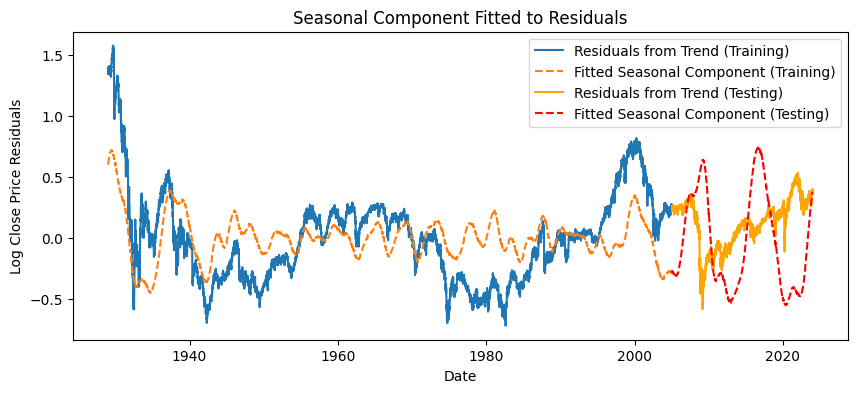

In [39]:
# Plot the seasonal predictions along with the residuals
plt.figure(figsize=(10, 4))
plt.plot(train_data.index, y_train_seas, label='Residuals from Trend (Training)')
plt.plot(train_data.index, train_data['Seasonal_Pred'], label='Fitted Seasonal Component (Training)', linestyle='--')
plt.plot(test_data.index, test_data['Trend_Residual'], label='Residuals from Trend (Testing)', color='orange')
plt.plot(test_data.index, test_data['Seasonal_Pred'], label='Fitted Seasonal Component (Testing)', linestyle='--', color='red')
plt.title('Seasonal Component Fitted to Residuals')
plt.xlabel('Date')
plt.ylabel('Log Close Price Residuals')
plt.legend()
plt.show()


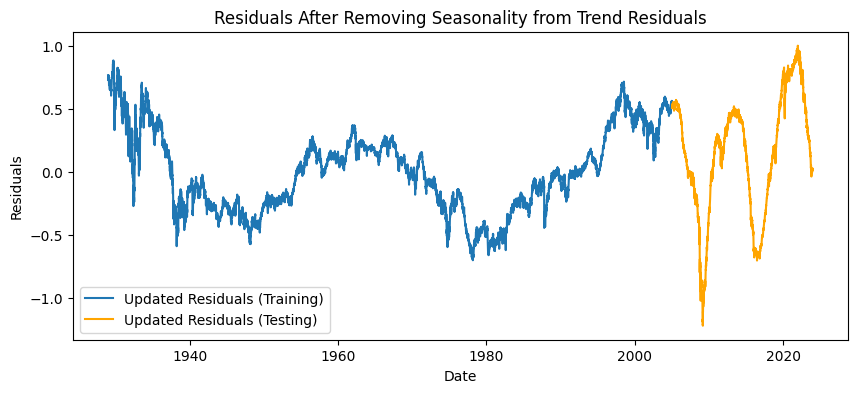

In [30]:
# Update the residuals after removing the seasonal component
train_data['Seasonal_Residuals'] = train_data['Trend_Residual'] - train_data['Seasonal_Pred']
test_data['Seasonal_Residuals'] = test_data['Trend_Residual'] - test_data['Seasonal_Pred']

# Plot the updated residuals to visualize the effectiveness of the seasonal model
plt.figure(figsize=(10, 4))
plt.plot(train_data.index, train_data['Seasonal_Residuals'], label='Updated Residuals (Training)')
plt.plot(test_data.index, test_data['Seasonal_Residuals'], label='Updated Residuals (Testing)', color='orange')
plt.title('Residuals After Removing Seasonality from Trend Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()


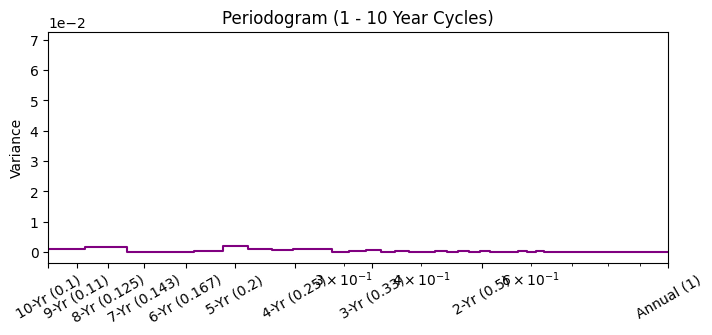

In [46]:
# Plot the periodogram for the updated residuals
fig, ax = plt.subplots(figsize=(8, 3))
plot_periodogram_longterm(train_data['Seasonal_Residuals'], ax=ax, focus_range=(1/10, 1), linear_scale=False)
plt.show()


The periodogram of the seasonal residuals (y - trend - seasonal) shows no significant remaining periodic components within the 1 to 10-year cycles, indicating that the higher-order Fourier terms have effectively captured the long-term seasonal cycles present in the data.

### Final Prediction Visualization (Trend + Seasonal)

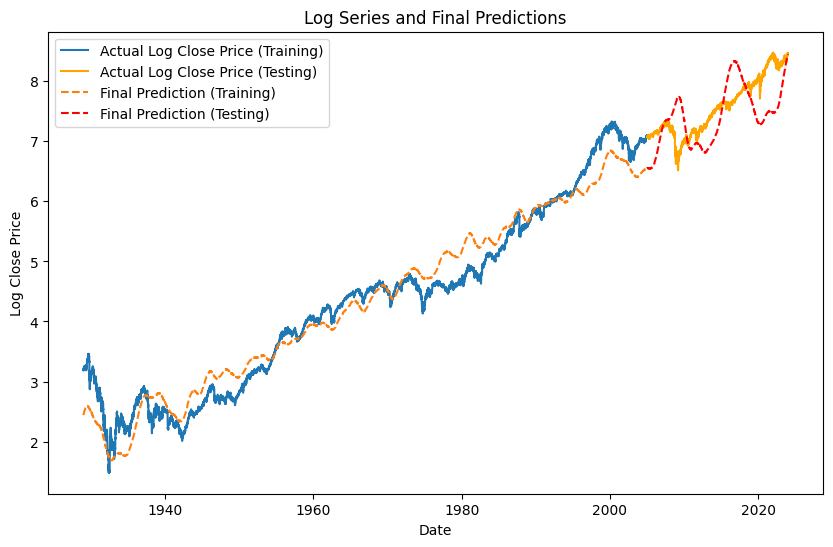

In [44]:
# Calculate the final predictions by summing the trend and seasonal predictions
train_data['Final_Pred'] = train_data['Trend_Pred'] + train_data['Seasonal_Pred']
test_data['Final_Pred'] = test_data['Trend_Pred'] + test_data['Seasonal_Pred']

# Plot the log series and the final predictions
plt.figure(figsize=(10, 6))

# Plot the actual log-transformed series
plt.plot(train_data.index, train_data['Log_Close'], label='Actual Log Close Price (Training)')
plt.plot(test_data.index, test_data['Log_Close'], label='Actual Log Close Price (Testing)', color='orange')

# Plot the in-sample final predictions
plt.plot(train_data.index, train_data['Final_Pred'], label='Final Prediction (Training)', linestyle='--')

# Plot the out-of-sample final predictions
plt.plot(test_data.index, test_data['Final_Pred'], label='Final Prediction (Testing)', linestyle='--', color='red')

plt.title('Log Series and Final Predictions')
plt.xlabel('Date')
plt.ylabel('Log Close Price')
plt.legend()
plt.show()


### Conclusion

- The plot shows the actual and predicted log-transformed closing prices for both training and testing periods. While the model captures the overall trend, the predictions deviate significantly from the actual prices (a lot of residuals), indicating limited forecasting accuracy. Keep in mind this model  is ultimately a combination of mathematical functions, so i kind of expected difficulty creating a forecast.

- However, there may be some predictive power in the timing of the ups and downs, especially with further tuning.

- From here, looking at autocorrelation might be a good idea to further capture the remaining residuals